# Predicting COVID-19 With Exponential Smoothing 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import date2num
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline
import json
plt.close("all")

euroData = pd.read_csv("data\euro_countries_padded.csv")
with open("data/iso_country_codes.json", "r") as read_file:
    countryCodes = json.load(read_file)

euroData

,Unnamed: 0,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,population,total_tests,new_tests,new_tests_smoothed
0,0,ALB,Albania,2019-12-31,0.0,0.0,0.000,2877800.0,0.0,0.0,0.0
1,1,ALB,Albania,2020-01-01,0.0,0.0,0.000,2877800.0,0.0,0.0,0.0
2,2,ALB,Albania,2020-01-02,0.0,0.0,0.000,2877800.0,0.0,0.0,0.0
3,3,ALB,Albania,2020-01-03,0.0,0.0,0.000,2877800.0,0.0,0.0,0.0
4,4,ALB,Albania,2020-01-04,0.0,0.0,0.000,2877800.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10641,10641,UKR,Ukraine,2020-11-06,430467.0,9850.0,8578.571,43733759.0,3521175.0,NaN,42174.0
10642,10642,UKR,Ukraine,2020-11-07,440188.0,9721.0,8779.857,43733759.0,3572433.0,51258.0,43312.0
10643,10643,UKR,Ukraine,2020-11-08,450934.0,10746.0,9064.714,43733759.0,3613899.0,41466.0,43050.0
10644,10644,UKR,Ukraine,2020-11-09,460331.0,9397.0,9270.143,43733759.0,3648292.0,34393.0,43440.0


In [2]:
#Creating Training sets

#For entire Europe:
def Europe_training_set(beg_day=100, end_day=euroData["date"].nunique()):
    cases_by_date = euroData.groupby("date")["new_cases"].sum().reset_index(name = "new_cases")
    if (end_day == euroData["date"].nunique()):
        t_set = cases_by_date[beg_day:]
    else:
        t_set = cases_by_date[beg_day:end_day]
    data = t_set.to_numpy()[:,1].astype(float)
    index = t_set.to_numpy()[:, 0]
    index = pd.date_range(start=index.min(), end=index.max())
    return data, index

#For Country
def Country_training_set(iso_code, beg_day=150, end_day=euroData["date"].nunique()):
    cases_by_date = euroData[euroData.iso_code==iso_code].groupby("date")["new_cases_smoothed"].sum().reset_index(name = "new_cases")
    if (end_day == euroData["date"].nunique()):
        t_set = cases_by_date[beg_day:]
    else:
        t_set = cases_by_date[beg_day:end_day]
    data = t_set.to_numpy()[:,1].astype(float)
    index = t_set.to_numpy()[:, 0]
    index = pd.date_range(start=index.min(), end=index.max())
    return data, index

In [3]:
#Initial Plot of Training set

def Initial_plot(data, index):
    fig, ax = plt.subplots()
    ax.plot(index, data)
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, (end-start)/10))
    plt.show()
    return

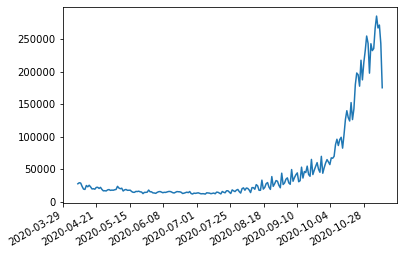

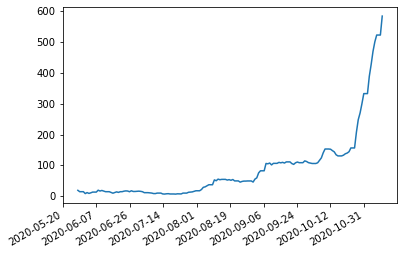

In [4]:
data, index = Europe_training_set()
Initial_plot(data, index)

data, index = Country_training_set('NOR')
Initial_plot(data, index)

# Simple Exponential Smoothing

In [5]:
def SES_plotter (covid_data, forecast_length=14, alpha_1=0.2, alpha_2=0.6):
    fit1 = SimpleExpSmoothing(covid_data, initialization_method="heuristic").fit(smoothing_level=alpha_1,optimized=False)
    fcast1 = fit1.forecast(forecast_length).rename(r'$\alpha='+str(alpha_1)+'$')
    fit2 = SimpleExpSmoothing(covid_data, initialization_method="heuristic").fit(smoothing_level=alpha_2,optimized=False)
    fcast2 = fit2.forecast(forecast_length).rename(r'$\alpha='+str(alpha_2)+'$')
    fit3 = SimpleExpSmoothing(covid_data, initialization_method="estimated").fit()
    fcast3 = fit3.forecast(forecast_length).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

    plt.figure(figsize=(12, 8))
    plt.plot(covid_data, marker='o', color='black')
    plt.plot(fit1.fittedvalues, marker='o', color='blue')
    line1, = plt.plot(fcast1, marker='o', color='blue')
    plt.plot(fit2.fittedvalues, marker='o', color='red')
    line2, = plt.plot(fcast2, marker='o', color='red')
    plt.plot(fit3.fittedvalues, marker='o', color='green')
    line3, = plt.plot(fcast3, marker='o', color='green')
    plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])
    

In [6]:
def ses_2(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


NameError: name 'SES_score' is not defined

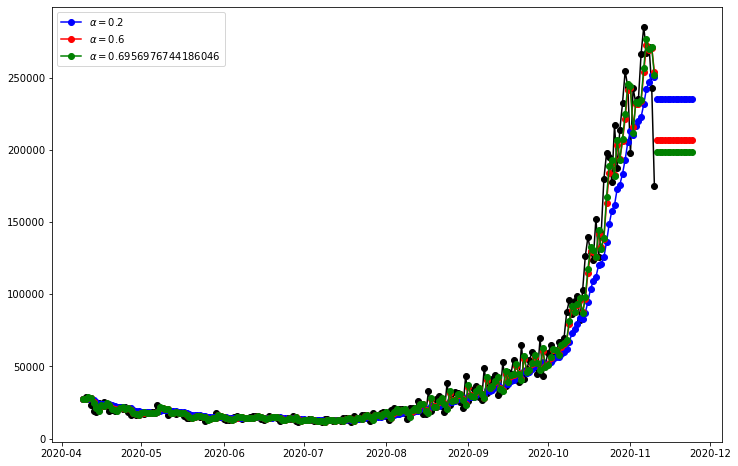

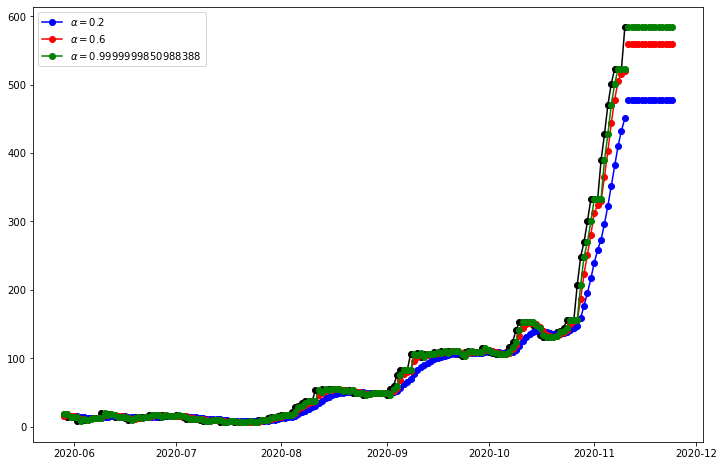

In [7]:
data, index = Europe_training_set()
covid_data = pd.Series(data, index)

SES_plotter(covid_data)

data, index = Country_training_set('NOR')
covid_data = pd.Series(data, index)

SES_plotter(covid_data)
SES_score(covid_data)

In [8]:
def Holt_plotter (covid_data, forecast_length=14, smoothing_level=0.8, smoothing_trend=0.2):
    fit1 = Holt(covid_data, initialization_method="estimated").fit(smoothing_level, smoothing_trend, optimized=False)
    fcast1 = fit1.forecast(forecast_length).rename("Holt's linear trend")
    fit2 = Holt(covid_data, exponential=True, initialization_method="estimated").fit(smoothing_level, smoothing_trend, optimized=False)
    fcast2 = fit2.forecast(forecast_length).rename("Exponential trend")
    fit3 = Holt(covid_data, damped_trend=True, initialization_method="estimated").fit(smoothing_level, smoothing_trend)
    fcast3 = fit3.forecast(forecast_length).rename("Additive damped trend")

    plt.figure(figsize=(12, 8))
    plt.plot(covid_data, marker='o', color='black')
    plt.plot(fit1.fittedvalues, color='blue')
    line1, = plt.plot(fcast1, marker='o', color='blue')
    plt.plot(fit2.fittedvalues, color='red')
    line2, = plt.plot(fcast2, marker='o', color='red')
    plt.plot(fit3.fittedvalues, color='green')
    line3, = plt.plot(fcast3, marker='o', color='green')
    plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


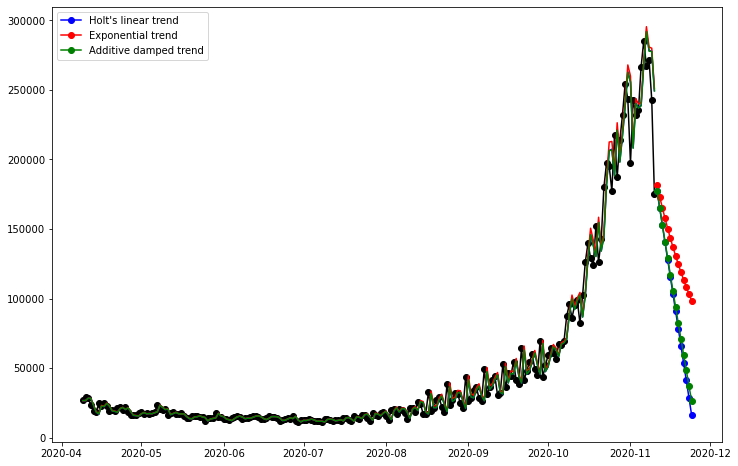

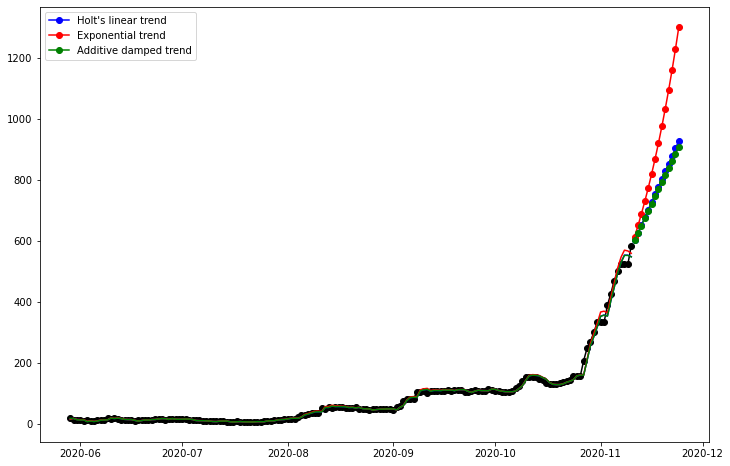

In [9]:
data, index = Europe_training_set()
covid_data = pd.Series(data, index)

Holt_plotter (covid_data)

data, index = Country_training_set('NOR')
covid_data = pd.Series(data, index)

Holt_plotter (covid_data)

In [10]:
def HW_simulation_plotter(covid_data, x_max=400000, seasonal_p=7,forecast_length=14, reps=100, region = "Europe"):
    fit = ExponentialSmoothing(covid_data, seasonal_periods=seasonal_p, trend='add', seasonal='mul', initialization_method="estimated").fit()
    simulations = fit.simulate(forecast_length, repetitions=reps, error='mul')

    ax = covid_data.plot(figsize=(10,6), marker='o', color='black',
               title="Forecasts and simulations from Holt-Winters' multiplicative method" )
    ax.set_ylabel("Daily new cases of COVID-19 in "+region)
    ax.set_ylim([0,x_max])
    ax.set_xlabel("Month")
    fit.fittedvalues.plot(ax=ax, style='--', color='green')
    simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', legend=False)
    fit.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
    plt.show()

C:\Users\borge\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


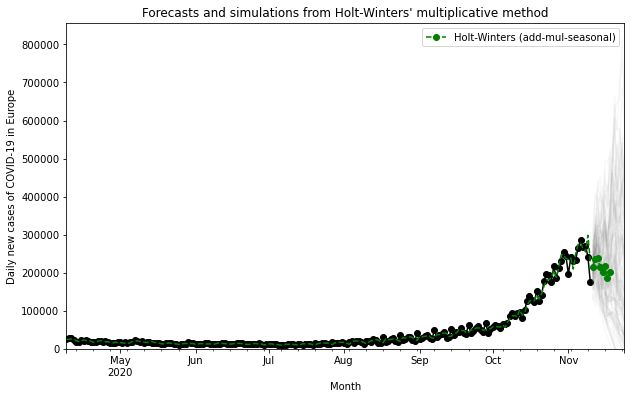

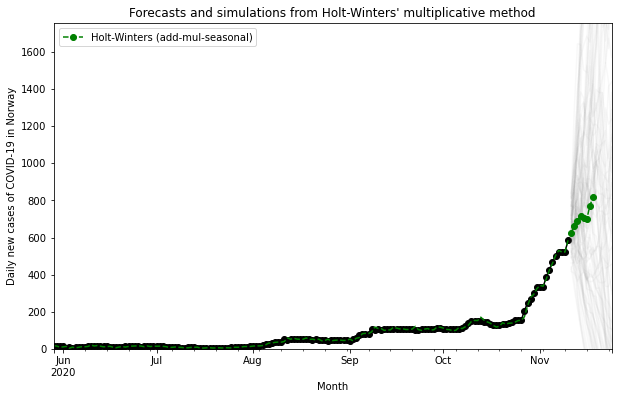

In [11]:
data_eur, index_eur = Europe_training_set()
covid_data_eur = pd.Series(data_eur, index_eur)

HW_simulation_plotter(covid_data_eur, np.amax(data_eur)*3)

data_nor, index_nor = Country_training_set('NOR')
covid_data_nor = pd.Series(data_nor, index_nor)

HW_simulation_plotter(covid_data_nor, np.amax(data_nor)*3, region = "Norway")